In [1]:
import pandas as pd 
import numpy as np 
import math
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import os
import pickle

## Model with Tokenization and One Hot Encoding

In [2]:
pos_embedding = pickle.load(open('/home/jupyter/CS230/data/pos_embedding_vec','rb'))
len(pos_embedding)

6291

In [3]:
neg_embedding = pickle.load(open('/home/jupyter/CS230/data/neg_embedding_vec_line','rb'))
len(neg_embedding)

187232

In [4]:
#sub smaple negative samples
neg_embedding=neg_embedding[:6291]
len(neg_embedding)

6291

In [5]:
#concatenating
all_embeddings=list(pos_embedding+neg_embedding)
len(all_embeddings)

12582

In [6]:
#creating two arrays with 1s and 0s
pos_target=np.ones(6291)
pos_target

array([1., 1., 1., ..., 1., 1., 1.])

In [7]:
neg_target=np.zeros(6291)
neg_target

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
all_target= np.append(pos_target,neg_target,axis=None)
all_target

array([1., 1., 1., ..., 0., 0., 0.])

In [10]:
embedding_size = 361
question_size = 104
def get_padded_embeddings(temp_df):
    #print("tdf", temp_df.shape)
    temp_df=temp_df.reshape(-1,361)
    zero_embeddings = np.zeros(embedding_size)
    truncated_df = temp_df[:question_size]
    #print(truncated_df.shape)
    #print(len(truncated_df),len(truncated_df[0]))
    #print(type([zero_embeddings]*(question_size-len(truncated_df))))
    #print(np.array([zero_embeddings]*(question_size - len(truncated_df))).shape)
    if(len(truncated_df)!=104):
        truncated_df = np.concatenate((truncated_df, np.array([zero_embeddings]*(question_size- len(truncated_df)))))
        #print(truncated_df.shape)
    return truncated_df

In [11]:
emb_vect_temp=np.array([get_padded_embeddings(line) for line in all_embeddings])

In [12]:
emb_vect_temp.shape

(12582, 104, 361)

In [50]:
all_embeddings_temp, all_embeddings_test,y_temp,y_test = train_test_split(emb_vect_temp, all_target, test_size = 0.30, shuffle=True, random_state = 42)


In [51]:
all_embeddings_train,all_embeddings_val,y_train,y_val= train_test_split(all_embeddings_temp,y_temp,test_size=0.20)

In [27]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [28]:
from keras import backend
print(len(backend.tensorflow_backend._get_available_gpus()))

1


In [15]:
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Bidirectional,Flatten
from sklearn.metrics import f1_score
from keras.utils import to_categorical

In [52]:
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True, input_shape=(104,361))))
model.add(Bidirectional(CuDNNLSTM(64)))
model.add(Dense(1, activation="sigmoid"))

In [53]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [55]:
history=model.fit(all_embeddings_train, y_train,validation_data=(all_embeddings_val,y_val), batch_size=None,nb_epoch=5,steps_per_epoch=1000, validation_steps=1000, verbose=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7045 samples, validate on 1762 samples
Epoch 1/5
1000/1000 [==============================] - 1633s 2s/step - loss: 0.3005 - acc: 0.8547 - val_loss: 1.6447 - val_acc: 0.6844
Epoch 2/5
1000/1000 [==============================] - 1633s 2s/step - loss: 0.2232 - acc: 0.8954 - val_loss: 1.8816 - val_acc: 0.6822
Epoch 3/5
1000/1000 [==============================] - 1634s 2s/step - loss: 0.2114 - acc: 0.9051 - val_loss: 1.9659 - val_acc: 0.6771
Epoch 4/5
1000/1000 [==============================] - 1634s 2s/step - loss: 0.1948 - acc: 0.9129 - val_loss: 1.8667 - val_acc: 0.6862
Epoch 5/5
1000/1000 [==============================] - 1633s 2s/step - loss: 0.1913 - acc: 0.9154 - val_loss: 1.5531 - val_acc: 0.6884


In [56]:
with open('/home/jupyter/notebooks/HistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

with open('/home/jupyter/notebooks/Model', 'wb') as file_mo:
        pickle.dump(model, file_mo)

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 104, 128)          218624    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               99328     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 318,081
Trainable params: 318,081
Non-trainable params: 0
_________________________________________________________________


In [58]:
score=model.evaluate(all_embeddings_test,y_test,steps=1000,verbose=1)
print("Test Accuracy",score[1])

1000/1000 [==============================] - 366s 366ms/step
Test Accuracy 0.6768211722373962


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


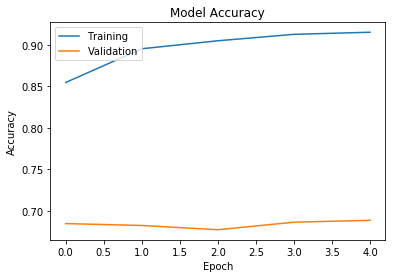

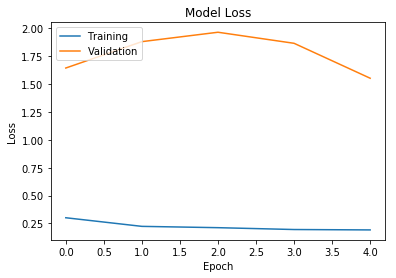

In [63]:
#visualization of test train and validation
print(history.history.keys())
# summarize history for accuracy
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(score[1])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('/home/jupyter/notebooks/Model_Acc.png', dpi=fig.dpi)

# summarize history for loss
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig('/home/jupyter/notebooks/Model_Loss.png', dpi=fig.dpi)

## Model with Tokenization but not One Hot Encoding Vector

In [31]:
pos_embedding_baseline = pickle.load(open('/home/jupyter/CS230/data/pos_embedding_vec_without_one_hot_encoding','rb'))
print(len(pos_embedding_baseline))
print(pos_embedding_baseline[0].shape)

6291
(300, 6)


In [32]:
neg_embedding_baseline = pickle.load(open('/home/jupyter/CS230/data/neg_embedding_vec_without_one_hot_encoding','rb'))
print(len(neg_embedding_baseline))
print(neg_embedding_baseline[0].shape)

187232
(300, 2)


In [33]:
#sub smaple negative samples
neg_embedding_baseline=neg_embedding_baseline[:6291]
len(neg_embedding_baseline)

6291

In [34]:
#concatenating
all_embeddings_baseline=list(pos_embedding_baseline+neg_embedding_baseline)
len(all_embeddings_baseline)

12582

In [35]:
#creating two arrays with 1s and 0s
pos_target_baseline=np.ones(6291)
pos_target_baseline

array([1., 1., 1., ..., 1., 1., 1.])

In [36]:
neg_target_baseline=np.zeros(6291)
neg_target_baseline

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
all_target_baseline= np.append(pos_target_baseline,neg_target_baseline,axis=None)
all_target_baseline

array([1., 1., 1., ..., 0., 0., 0.])

In [38]:
embedding_size_baseline = 300
question_size = 104
def get_padded_embeddings_baseline(temp_df):
    #print("tdf", temp_df.shape)
    temp_df=temp_df.reshape(-1,300)
    zero_embeddings = np.zeros(embedding_size_baseline)
    truncated_df = temp_df[:question_size]
    #print(truncated_df.shape)
    #print(len(truncated_df),len(truncated_df[0]))
    #print(type([zero_embeddings]*(question_size-len(truncated_df))))
    #print(np.array([zero_embeddings]*(question_size - len(truncated_df))).shape)
    if(len(truncated_df)!=104):
        truncated_df = np.concatenate((truncated_df, np.array([zero_embeddings]*(question_size- len(truncated_df)))))
        #print(truncated_df.shape)
    return truncated_df

In [39]:
emb_vect_temp_baseline=np.array([get_padded_embeddings_baseline(line) for line in all_embeddings_baseline])

In [40]:
emb_vect_temp_baseline.shape

(12582, 104, 300)

In [41]:
all_embeddings_temp_baseline, all_embeddings_test_baseline,y_temp_baseline,y_test_baseline = train_test_split(emb_vect_temp_baseline, all_target_baseline, test_size = 0.30, shuffle=True, random_state = 42)


In [42]:
all_embeddings_train_baseline,all_embeddings_val_baseline,y_train_baseline,y_val_baseline= train_test_split(all_embeddings_temp_baseline,y_temp_baseline,test_size=0.20, shuffle=True, random_state = 42)


In [43]:
model_baseline = Sequential()
model_baseline.add(Bidirectional(CuDNNLSTM(64, return_sequences=True, input_shape=(104,361))))
model_baseline.add(Bidirectional(CuDNNLSTM(64)))
model_baseline.add(Dense(1, activation="sigmoid"))

In [44]:
model_baseline.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
history_baseline = model_baseline.fit(all_embeddings_train_baseline, y_train_baseline, validation_data=(all_embeddings_val_baseline,y_val_baseline),batch_size=None,nb_epoch=5,steps_per_epoch=1000, validation_steps=1000, verbose=1)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Train on 7045 samples, validate on 1762 samples
Epoch 1/5
1000/1000 [==============================] - 1231s 1s/step - loss: 0.3123 - acc: 0.8473 - val_loss: 1.4982 - val_acc: 0.6958
Epoch 2/5
1000/1000 [==============================] - 1230s 1s/step - loss: 0.2281 - acc: 0.8930 - val_loss: 1.6791 - val_acc: 0.6924
Epoch 3/5
1000/1000 [==============================] - 1232s 1s/step - loss: 0.2069 - acc: 0.9050 - val_loss: 1.6198 - val_acc: 0.6890
Epoch 4/5
1000/1000 [==============================] - 1232s 1s/step - loss: 0.1949 - acc: 0.9137 - val_loss: 1.6705 - val_acc: 0.6827
Epoch 5/5
1000/1000 [==============================] - 1237s 1s/step - loss: 0.1762 - acc: 0.9230 - val_loss: 1.7199 - val_acc: 0.6691


In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 104, 128)          218624    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               99328     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 318,081
Trainable params: 318,081
Non-trainable params: 0
_________________________________________________________________


In [65]:
with open('/home/jupyter/notebooks/HistoryDict_baseline', 'wb') as file_pi:
        pickle.dump(history_baseline.history, file_pi)

with open('/home/jupyter/notebooks/Model_baseline', 'wb') as file_mo:
        pickle.dump(model_baseline, file_mo)

In [49]:
score_baseline=model_baseline.evaluate(all_embeddings_test_baseline,y_test_baseline,steps=1000,verbose=1)
print("Test Accuracy",score_baseline[1])

1000/1000 [==============================] - 512s 512ms/step
Test Accuracy 0.6757615804672241


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


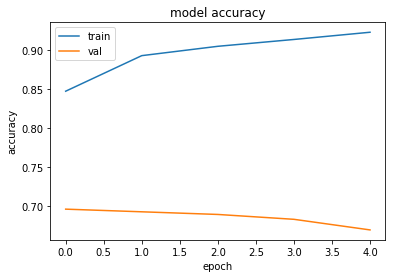

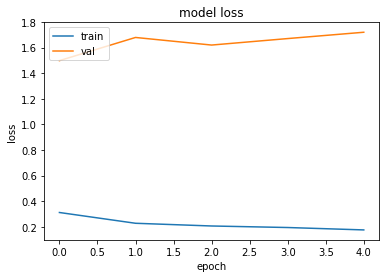

In [64]:
#visualization of test train and validation
print(history_baseline.history.keys())
# summarize history for accuracy
fig = plt.figure()
plt.plot(history_baseline.history['acc'])
plt.plot(history_baseline.history['val_acc'])
plt.plot(score[1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig.savefig('/home/jupyter/notebooks/Baseline_Model_Acc.png', dpi=fig.dpi)
# summarize history for loss
fig = plt.figure()
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig.savefig('/home/jupyter/notebooks/Baseline_Model_Loss.png', dpi=fig.dpi)

## Baseline Using fastText --- Data Preprocessing

In [ ]:
import zipfile

pos_file = '/home/jupyter/notebooks/Current_lines.zip'
zip_ref = zipfile.ZipFile(pos_file, 'r')
zip_ref.extractall()
zip_ref.close()

neg_file = '/home/jupyter/notebooks/filtered_context.zip'
zip_ref = zipfile.ZipFile(neg_file, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
pos_file_path = '/home/jupyter/notebooks/Current_lines'
neg_file_path = '/home/jupyter/notebooks/filtered_context'

pos_file = os.listdir(pos_file_path)
neg_file = os.listdir(neg_file_path)

print(len(pos_file))
print(len(neg_file))

In [ ]:
with open('/home/jupyter/notebooks/pos_review_train.txt', 'w') as f1, open('/home/jupyter/notebooks/pos_review_test.txt', 'w') as f2:
    for i in pos_file[:4750]:
        f_rd = open(pos_file_path +"/" + str(i), 'r')
        lines = f_rd.readlines()
        if len(lines) == 0:
            continue
        for l in lines:
            l = "__label__1" + l
            f1.write(l)
            
    for i in pos_file[4750:]:
        f_rd = open(pos_file_path +"/" + str(i), 'r')
        lines = f_rd.readlines()
        if len(lines) == 0:
            continue
        for l in lines:
            l = "__label__1" + l
            f2.write(l)
f1.close()
f2.close()

In [ ]:
with open('/home/jupyter/notebooks/neg_review_train.txt', 'w') as f1, open('/home/jupyter/notebooks/neg_review_test.txt', 'w') as f2:
    for i in neg_file[:75]:
        f_rd = open(neg_file_path +"/" + str(i), 'r')
        lines = f_rd.readlines()
        if len(lines) == 0:
            continue
        
        for l in lines:
            l = "__label__0" + l 
            f1.write(l)
        
    for i in neg_file[75:85]:
        f_rd = open(neg_file_path +"/" + str(i), 'r')
        lines = f_rd.readlines()
        if len(lines) == 0:
            continue
        
        for l in lines:
            l = "__label__0" + l 
            f2.write(l)

f1.close()
f2.close()

In [ ]:
with open('/home/jupyter/notebooks/review_train.txt', 'w') as f_wr, open('/home/jupyter/notebooks/pos_review_train.txt', 'r') as f_pos, with open('/home/jupyter/notebooks/neg_review_train.txt', 'r') as f_neg:
    f_wr.write(f_pos.read())
    f_wr.write(f_neg.read())
f_wr.close()

In [ ]:
with open('/home/jupyter/notebooks/review_text.txt', 'w') as f_wr, open('/home/jupyter/notebooks/pos_review_text.txt', 'r') as f_pos, with open('/home/jupyter/notebooks/neg_review_text.txt', 'r') as f_neg:
    f_wr.write(f_pos.read())
    f_wr.write(f_neg.read())
f_wr.close()